First, let's import and have a look at the data. 
It includes a "success" field, identifying successful and failed acts. 

<function matplotlib.pyplot.show>

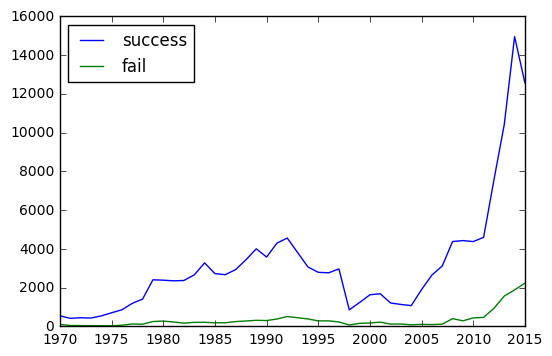

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
d = pd.read_csv('../input/globalterrorismdb_0616dist.csv', encoding='ISO-8859-1',  usecols=[0, 1, 2, 3, 8, 11, 13, 14, 26, 29, 35, 37, 84, 100, 103])
d = d.rename(
    columns={'eventid':'id', 'iyear':'year', 'imonth':'month', 'iday':'day',
             'country_txt':'country', 'provstate':'state', 'success':'success','targtype1_txt':'target', 'targsubtype1_txt' : 'targetsub',
             'weaptype1_txt':'weapon', 'attacktype1_txt':'attack',
             'nkill':'fatalities', 'nwound':'injuries'})
d['fatalities'] = d['fatalities'].fillna(0).astype(int)
d['injuries'] = d['injuries'].fillna(0).astype(int)
pd.options.mode.chained_assignment = None
d['day'][d.day == 0] = 1
d['month'][d.month == 0] = 1
d['date'] = pd.to_datetime(d[['day', 'month', 'year']])

success_counts=d[d.success==1]['year'].value_counts().sort_index()
fail_counts=d[d.success==0]['year'].value_counts().sort_index()
plt.plot(success_counts,label="success")
plt.plot(fail_counts,label="fail")
plt.legend(loc=2)
plt.show

There are far more successful acts then failed acts. It may mean either : 

 - data is not complete and failed terrorist acts are 100% reported.

 - the high success rate is real.

I suspect the reality is a mix between thee two reasons. A failed terrorist acts may not hit the headlines and therefore will be absent from the data.

Let's have a look at this success rate by country see if we can get more insight. We'll keep only the countries where at least 500 acts were reported for the sake of readability.

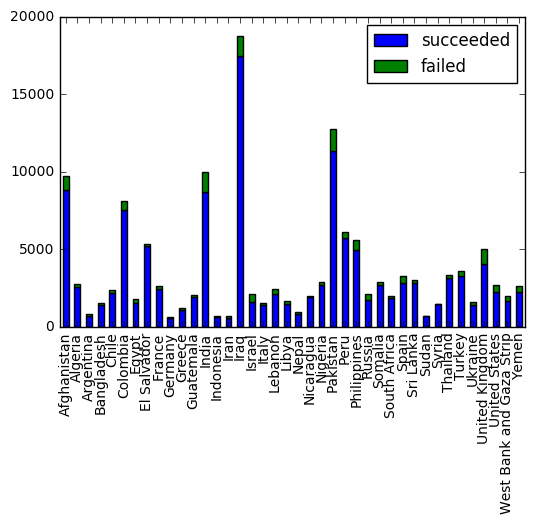

In [2]:
import pandas as pd
#import the data and rename the columns
d = pd.read_csv('../input/globalterrorismdb_0616dist.csv', encoding='ISO-8859-1',  usecols=[0, 1, 2, 3, 8, 11, 13, 14, 26, 29, 35, 37, 84, 100, 103])
 
d = d.rename(
    columns={'eventid':'id', 'iyear':'year', 'imonth':'month', 'iday':'day',
             'country_txt':'country', 'provstate':'state', 'success':'success','targtype1_txt':'target', 'targsubtype1_txt' : 'targetsub',
             'weaptype1_txt':'weapon', 'attacktype1_txt':'attack',
             'nkill':'fatalities', 'nwound':'injuries'})
d['day'][d.day == 0] = 1
d['month'][d.month == 0] = 1
d['date'] = pd.to_datetime(d[['day', 'month', 'year']])
count_by_country = d[d.success== 1].groupby('country').count()['date']

df1=pd.DataFrame(index=count_by_country[count_by_country>500].index.unique())
df1["succeeded"]= d[d.success== 1].groupby('country')['date'].count().fillna(0)
df1["failed"]= d[d.success!= 1].groupby('country')['date'].count().fillna(0).sort_values(0,ascending=False)
df1[df1.failed>0].plot(kind='bar', stacked=True)

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Benchmark: 
0.875972380037


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest accuracy score: 
0.887160213268
AUC = 0.5760


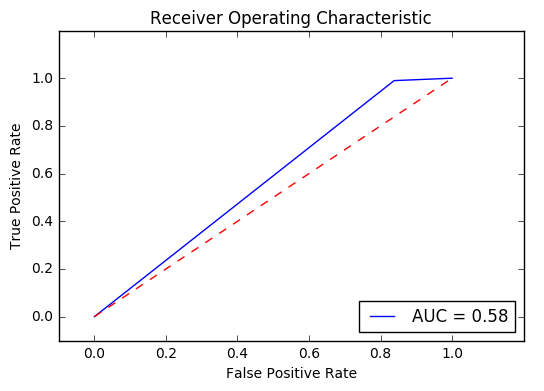

In [3]:
# -*- coding: utf-8 -*-
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
#import the data and rename the columns
d = pd.read_csv('../input/globalterrorismdb_0616dist.csv', encoding='ISO-8859-1',  usecols=[0, 1, 2, 3, 8, 11, 13, 14, 26, 29, 35, 37, 84, 100, 103])
 
d = d.rename(
    columns={'eventid':'id', 'iyear':'year', 'imonth':'month', 'iday':'day',
             'country_txt':'country', 'provstate':'state', 'success':'success','targtype1_txt':'target', 'targsubtype1_txt' : 'targetsub',
             'weaptype1_txt':'weapon', 'attacktype1_txt':'attack',
             'nkill':'fatalities', 'nwound':'injuries'})

d=d[d['year']>2010]

success=pd.DataFrame(d['success'])

#map the string fields into numerical
features=pd.concat( [pd.get_dummies(d['attack'],prefix='atk'),
                    pd.get_dummies(d['country'],prefix='ctry'),
                    pd.get_dummies(d['weapon'],prefix='wpn')     
                    ],axis=1)

#split the data into train and test datasets
features_train, features_test,target_train, target_test = train_test_split(features,success, test_size = 0.2,random_state=0)

#Dummy benchmark : predict 100% success
print("Benchmark: " )
print(accuracy_score(target_test['success'],np.ones(len(target_test['success']))))

ids = features_test.index

#Random Forest
forest=RandomForestClassifier(n_estimators=10)
forest = forest.fit( features_train, target_train )
output = forest.predict(features_test).astype(int)
results = pd.DataFrame(data=output,index=ids,columns=['prediction'])
results = target_test.join(results)#.drop(['attack','target','weapon','country'],axis=1)

print("Random Forest accuracy score: " )
print(accuracy_score(results['success'],results['prediction']))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, output)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC = %0.4f'% roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()